1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


# Pre-requistes

In [68]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!date

Wed Feb 14 04:33:07 EST 2018


In [3]:
project_name='plant-seedlings-classification'

In [4]:
import os, sys

In [5]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [6]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import os
from planet import *

In [7]:
PATH = "/home/paperspace/data/seeds/"
#PATH = "/Users/vinod/programming/DL/data/seedlings/"
assert os.path.exists(PATH)

## Get data

### Directory based structure

In [8]:
!ls {PATH}

lr_plot.png  sample_submission.csv.zip	tmp    train.zip
models	     test			train  valid


In [9]:
notebook_dir = os.getcwd()
notebook_dir

'/home/paperspace/fastai/courses/dl1'

In [10]:
os.chdir(PATH)

In [11]:
! pwd

/home/paperspace/data/seeds


In [12]:
dir_list = os.listdir('train/')
dir_list.remove('.DS_Store')
dir_list

ValueError: list.remove(x): x not in list

In [ ]:
from random import sample

for dir in dir_list:
    print(dir)
    #files = np.random.permutation(os.listdir(f'train/{dir}'))
    files = os.listdir(f'train/{dir}')
    no_of_valid_files = round(len(files) / 10) # 10%
    print(no_of_valid_files)
    random_files = sample(files, no_of_valid_files)
    print(random_files[:3])
    for file in random_files:
        os.renames(f'{PATH}/train/{dir}/{file}', f'valid/{dir}/{file}') 
    os.listdir(f'{PATH}valid/{dir}/')

In [13]:
!ls {PATH}valid

Black-grass  Common Chickweed  Loose Silky-bent   Shepherds Purse
Charlock     Common wheat      Maize		  Small-flowered Cranesbill
Cleavers     Fat Hen	       Scentless Mayweed  Sugar beet


In [14]:
# MAX size
files = !ls -S {PATH}valid/Maize | head
files

['c9b1820d0.png',
 '5c7abc049.png',
 '9d588ace5.png',
 '3ad5d809c.png',
 'b496ed692.png',
 '084d21b80.png',
 'a5c2eec2d.png',
 '85ae913c3.png',
 '66e90b455.png',
 '266211c3c.png']

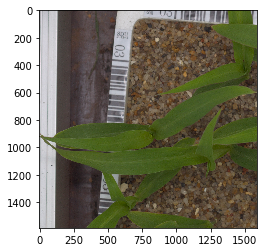

In [15]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [36]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(1588, 1588, 3)

In [37]:
# MIN size
files = !ls -rS {PATH}valid/Maize | head
files

['16e38d4af.png',
 '69f06fcbc.png',
 '7446f241c.png',
 '50c80a5e4.png',
 '8bfe6860d.png',
 '18b6755a1.png',
 '55083690a.png',
 '3ef465952.png',
 '606d5c83f.png',
 'ff4b55219.png']

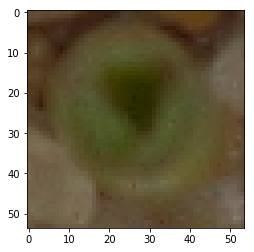

In [38]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [39]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(54, 54, 3)

In [16]:
os.chdir(notebook_dir)

In [17]:
def get_tfms(f_model, size): return tfms_from_model(f_model, size)

In [18]:
def get_aug_tfms(f_model, size): return tfms_from_model(f_model, size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [19]:
def get_data_from_csv(f_model, sz, tfms):
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [20]:
def get_data_from_dir(f_mode, sz, tfms, **kwargs):
    return ImageClassifierData.from_paths(PATH, bs, tfms=tfms_from_model(arch, sz), test_name='test')

# Enable data augmentation, and precompute=True

## Initial model setup

In [69]:
arch=resnet34
size=60
bs=64 # default
#metrics=[f2]

In [70]:
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size))

In [71]:
learn = ConvLearner.pretrained(arch, data, ps=0.5)

# Use lr_find() to find highest learning rate where loss is still clearly improving

In [72]:
discovered_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 61/67 [00:08<00:00,  7.37it/s, loss=16.6]


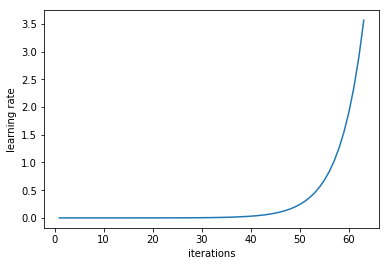

In [73]:
learn.sched.plot_lr()

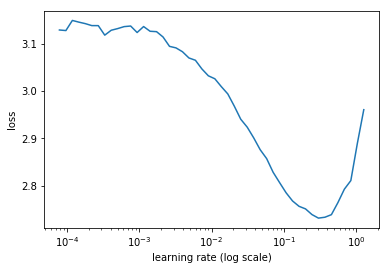

In [26]:
learn.sched.plot()

# Train last layer from precomputed activations for 1-2 epochs

In [27]:
#learning_rate = 0.15
learning_rate = 0.1
learning_rates = [learning_rate/9, learning_rate/3, learning_rate]

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.225823   1.423545   0.514251  
    1      1.903604   1.326168   0.528646                 
    2      1.580865   1.210331   0.55013                  
    3      1.500389   1.193895   0.588469                 
    4      1.384538   1.124223   0.617983                 
    5      1.283774   1.076758   0.633102                 
    6      1.189443   1.059468   0.637514                 

CPU times: user 6min 57s, sys: 18 s, total: 7min 15s
Wall time: 1min 11s


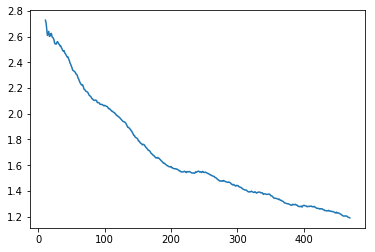

In [28]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.153444   0.709687   0.738354  
    1      0.840446   0.565215   0.797888                  
    2      0.529809   0.380105   0.866247                  
    3      0.507727   0.521682   0.818866                  
    4      0.37978    0.434452   0.867694                  
    5      0.231527   0.275786   0.90748                   
    6      0.162451   0.280379   0.912616                  

CPU times: user 7min 27s, sys: 29 s, total: 7min 56s
Wall time: 1min 47s


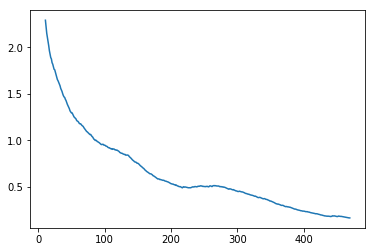

In [29]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [30]:
size = 150
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.07016    0.687183   0.765191  
    1      0.874706   0.564799   0.812283                  
    2      0.771255   0.505655   0.839627                  
    3      0.747425   0.470259   0.844256                  
    4      0.7059     0.462984   0.834491                  
    5      0.662544   0.42301    0.855975                  
    6      0.619651   0.424621   0.858652                  

CPU times: user 7min 59s, sys: 33.4 s, total: 8min 33s
Wall time: 1min 59s


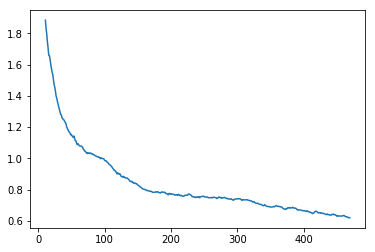

In [31]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.689565   0.359268   0.882089  
    1      0.478658   0.277085   0.892361                  
    2      0.296356   0.175594   0.953125                  
    3      0.320827   0.285244   0.895761                  
    4      0.233211   0.154166   0.956308                  
    5      0.138249   0.141111   0.964844                  
    6      0.08565    0.124756   0.966797                   

CPU times: user 9min 53s, sys: 1min 18s, total: 11min 11s
Wall time: 4min 30s


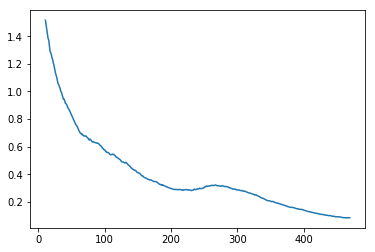

In [32]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [33]:
size = 400
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.569273   0.372221   0.885272  
    1      0.475311   0.295127   0.905527                  
    2      0.408819   0.282307   0.911386                  
    3      0.37186    0.294649   0.900897                  
    4      0.359245   0.228502   0.919198                  
    5      0.326832   0.227021   0.918475                  
    6      0.305606   0.218168   0.918475                  

CPU times: user 15min 21s, sys: 3min 34s, total: 18min 55s
Wall time: 8min 22s


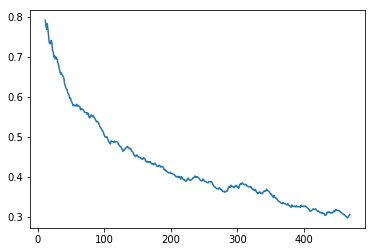

In [34]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.587671   0.278897   0.910663  
    1      0.386766   0.385745   0.889178                  
    2      0.229706   0.12827    0.96412                   
    3      0.226571   0.191162   0.939959                  
    4      0.162946   0.113823   0.973886                  
    5      0.105874   0.092263   0.975839                  
    6      0.07331    0.083795   0.977792                   

CPU times: user 25min 8s, sys: 6min 55s, total: 32min 3s
Wall time: 21min 33s


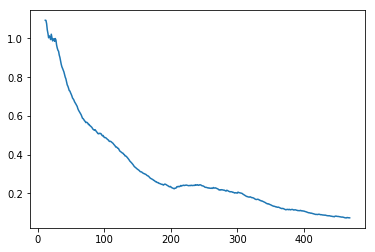

In [35]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

## Current latest standing doesn't include the following fit'

In [36]:
size = 500
bs=32
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.091506   0.08895    0.980864  
    1      0.092439   0.08485    0.980864                     
    2      0.082441   0.085513   0.980864                     
    3      0.10312    0.103643   0.966281                     
    4      0.08237    0.098423   0.976698                     
    6      0.065622   0.090983   0.978781                     

CPU times: user 19min 19s, sys: 4min 37s, total: 23min 57s
Wall time: 11min 24s


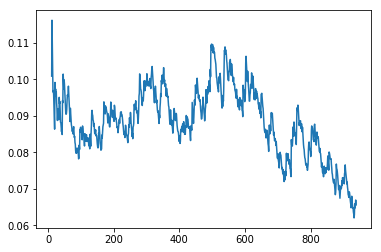

In [37]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.399495   0.175753   0.945448  
    1      0.318488   0.231159   0.926698                    
    2      0.154993   0.111336   0.968364                    
    3      0.349212   0.469012   0.855864                    
    4      0.228664   0.172897   0.953781                    
    5      0.106808   0.086345   0.980864                    
    6      0.065318   0.085859   0.976698                     

CPU times: user 34min 9s, sys: 9min 57s, total: 44min 7s
Wall time: 31min 34s


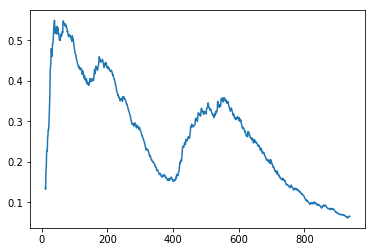

In [38]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

# Check accuracy

## Validation set

In [39]:
log_preds, y = learn.TTA()

In [40]:
log_preds.shape

(5, 475, 12)

In [41]:
log_preds[:,0,:]

array([[ -0.71741, -13.96892, -12.6822 , -10.22568,  -7.39807,  -9.06561,  -0.6719 , -11.2068 ,  -8.76548,
        -11.65141,  -8.11909, -12.25463],
       [ -0.71741, -13.96892, -12.6822 , -10.22568,  -7.39807,  -9.06561,  -0.6719 , -11.2068 ,  -8.76548,
        -11.65141,  -8.11909, -12.25463],
       [ -0.71741, -13.96892, -12.6822 , -10.22568,  -7.39807,  -9.06561,  -0.6719 , -11.2068 ,  -8.76548,
        -11.65141,  -8.11909, -12.25463],
       [ -0.71741, -13.96892, -12.6822 , -10.22568,  -7.39807,  -9.06561,  -0.6719 , -11.2068 ,  -8.76548,
        -11.65141,  -8.11909, -12.25463],
       [ -0.71741, -13.96892, -12.6822 , -10.22568,  -7.39807,  -9.06561,  -0.6719 , -11.2068 ,  -8.76548,
        -11.65141,  -8.11909, -12.25463]], dtype=float32)

In [42]:
y.shape

(475,)

In [43]:
y[:5]

array([0, 0, 0, 0, 0])

In [44]:
probs = np.mean(np.exp(log_preds), 0)

In [45]:
probs.shape

(475, 12)

In [46]:
probs[0,:]

array([ 0.48801,  0.     ,  0.     ,  0.00004,  0.00061,  0.00012,  0.51074,  0.00001,  0.00016,  0.00001,
        0.0003 ,  0.     ], dtype=float32)

In [47]:
accuracy(probs, y)

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


### F1 metrics

In [48]:
from sklearn.metrics import f1_score

In [49]:
probs_idx = np.argmax(probs, axis=1)
probs_idx.shape

(475,)

In [50]:
f1_score(y, probs_idx, average='macro')

0.97427476611838681

In [51]:
f1_score(y, probs_idx, average='micro') # kaggle

0.97684210526315784

In [52]:
f1_score(y, probs_idx, average='weighted')

0.97678065005326442

## Test set

In [55]:
learn.data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [56]:
test_log_preds, test_y = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_preds), 0)
print(accuracy(test_probs, test_y))

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


In [57]:
print(test_probs.shape)
print(test_probs[:4])
print(test_probs[0, 0])

(794, 12)
[[ 0.03927  0.00016  0.00096  0.00005  0.95727  0.0003   0.0014   0.00006  0.00002  0.00001  0.00002  0.00049]
 [ 0.       0.00001  0.00001  0.       0.       0.00052  0.       0.00001  0.       0.       0.99943  0.     ]
 [ 0.       0.00003  0.00001  0.       0.       0.00016  0.       0.00002  0.       0.       0.99977  0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       1.       0.       0.       0.       0.     ]]
0.0392655


In [58]:
class_indexes = np.argmax(test_probs, axis=1)

In [59]:
learn.data.classes[class_indexes[0]]

'Common wheat'

# Submit to kaggle (optional)

In [60]:
test_classes = [learn.data.classes[i] for i in class_indexes]
print(len(test_classes))
print(test_classes[:5])


794
['Common wheat', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Maize', 'Small-flowered Cranesbill']


In [61]:
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(len(test_filenames))
print(test_filenames[:5])

794
['test/79e5ea8fa.png', 'test/3a909ead8.png', 'test/599691cd9.png', 'test/5ca2687a4.png', 'test/3dd52bd2a.png']


In [62]:
fileIds = np.array([f[5:] for f in test_filenames])
fileIds[:5]

array(['79e5ea8fa.png', '3a909ead8.png', '599691cd9.png', '5ca2687a4.png', '3dd52bd2a.png'], 
      dtype='<U13')

In [63]:
submission = np.stack([fileIds,test_classes], axis=1)
submission[:5]

array([['79e5ea8fa.png', 'Common wheat'],
       ['3a909ead8.png', 'Small-flowered Cranesbill'],
       ['599691cd9.png', 'Small-flowered Cranesbill'],
       ['5ca2687a4.png', 'Maize'],
       ['3dd52bd2a.png', 'Small-flowered Cranesbill']], 
      dtype='<U25')

In [64]:
!pwd

/home/paperspace/fastai/courses/dl1


In [65]:
now = datetime.datetime.now()
submission_file_name = f'plant-seed-submission-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%s,%s', header='file,species', comments='')

In [66]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/paperspace/fastai/courses/dl1/plant-seed-submission-2018-02-14 09:17:52.504556.csv

In [67]:
!date

Wed Feb 14 09:17:56 EST 2018
